In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import resnet34, EfficientNet_B1_Weights
from torchvision.datasets import CIFAR10
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
from torchmetrics.regression import KendallRankCorrCoef,PearsonCorrCoef
import os
import time
import numpy as np
import pandas as pd

from PIL import Image

from sklearn import preprocessing
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
from torchvision.transforms import AutoAugmentPolicy, AutoAugment, RandomPerspective, RandomAffine, ElasticTransform, Grayscale
from copy import copy

import urllib
import cv2

torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [3]:
### Model based on Z. Zou, X. Zhang, H. Liu, Z. Li, A. Hussain, i J. Li, „A novel multimodal fusion network based on a joint coding model for lane line segmentation”. http://arxiv.org/abs/2103.11114

In [4]:
data_root = "./dataStructure/training"
validation_root="./dataStructure/validation"
txt_file_train = "label_2"

thing_classes = ['Pedestrian']
train_img_count = 5

In [5]:
def get_pedestrian_label(data_root, txt_folder):
    annotations = []
    labels_folder =os.path.join(data_root, txt_folder)
    for file in os.listdir(labels_folder):
        file_id = file[:-4]
        file_path = os.path.join(labels_folder,file)
        with open(file_path, 'r') as opened_file:
            bb_list = []
            for line in opened_file:
              coordinates = line.split()
              if coordinates == []:
                continue
              class_name, _, _,_, xmin, ymin, xmax, ymax, _, _ ,_ , _, _, _, _= map(str, coordinates)
              if class_name in thing_classes:
                xmin = int(float(xmin))
                ymin = int(float(ymin))
                xmax = int(float(xmax))
                ymax = int(float(ymax))
                bb_list.append((xmin,ymin,xmax,ymax))
        annotations.append((file_id,bb_list))

    return annotations

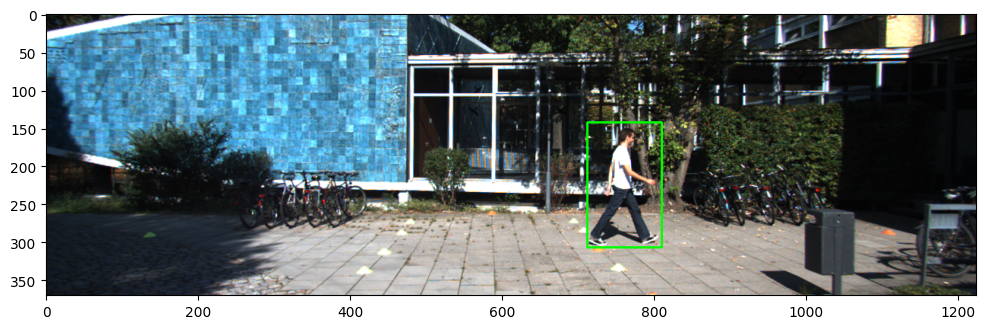

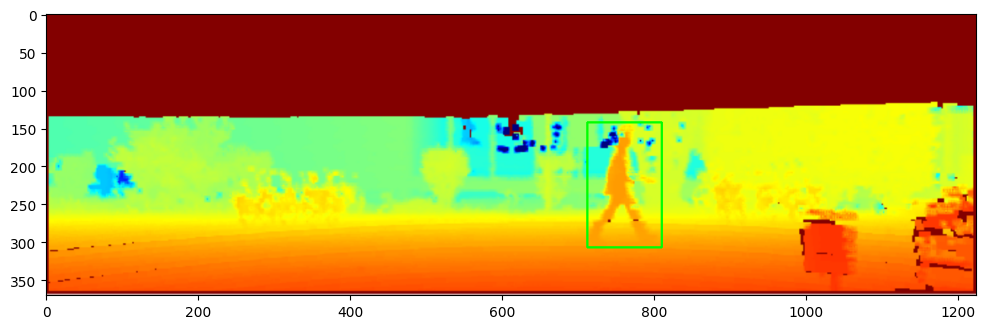

In [7]:
train_data_dict = get_pedestrian_label(data_root, txt_file_train)
import random

for d in random.sample(train_data_dict, 1):
    image_path = os.path.join(data_root, "image_2", d[0] + ".png")
    img = cv2.imread(image_path)
    h1, w1, _ = img.shape
    for bb in d[1]:
      x1 = bb[0]
      x2 = bb[2]
      y1= bb[1]
      y2 = bb[3]
      cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  

    plt.figure(figsize = (12, 12))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

for d in random.sample(train_data_dict, 1):
    image_path = os.path.join(data_root, "densec", d[0] + ".png")
    imgdense = cv2.imread(image_path)
    imgdense = cv2.resize(imgdense, (w1, h1))
    for bb in d[1]:
        x1, y1, x2, y2 = bb
        cv2.rectangle(imgdense, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    plt.figure(figsize = (12, 12))
    plt.imshow(imgdense)
    plt.show()


In [ ]:
def writeBboxColor(imagename,train_data_dict):
  for label in train_data_dict:
    if label[0]==imagename:
      image_path = os.path.join(data_root, "image_2", imagename + ".png")
      img = Image.open(image_path)
      return img

In [ ]:
def writeBboxDense(imagename,train_data_dict):
  for label in train_data_dict:
    if label[0]==imagename:
      image_path = os.path.join(data_root, "densec", imagename + ".png")
      img = Image.open(image_path)
      return img

In [ ]:
class kitti_loader:
    def __init__(self, directory,transform):
            txt_file_train = "label_2"
            self.root_dir = directory
            self.transform = transform
            self.train_data_dict = get_pedestrian_label(data_root, txt_file_train) 
    def __len__(self):
            return len(os.listdir(self.root_dir+"/calib"))

    def __getitem__(self, idx):
        formatedidx=f"{idx:06}"
        if torch.is_tensor(formatedidx):
            formatedidx = idx.tolist()
        image = writeBboxColor(formatedidx,self.train_data_dict)
        dense = writeBboxDense(formatedidx,self.train_data_dict)
        if self.transform:
            image = self.transform(image)
            dense = self.transform(dense)
        labelList=[]
        for label in train_data_dict:
                if label[0]==formatedidx:
                    if label[1]!=[]:
                        labelList.append(label[1][0])
                    else:
                        labelList.append((0,0,0,0))
        labelList=torch.tensor(labelList)
        return image,dense,labelList

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Block A pink
        self.block1_conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.block1_bn = nn.BatchNorm2d(32)
        self.block1_relu = nn.ReLU()

        # Block B pink
        self.block2_conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.block2_bn = nn.BatchNorm2d(32)
        self.block2_relu = nn.ReLU()

        # Block C pink
        self.merged_conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.merged_bn = nn.BatchNorm2d(64)
        self.merged_relu = nn.ReLU()

        # Block D red
        self.resnet34 = models.resnet34(pretrained=True)
        self.resnet34_first= nn.Sequential(*list(self.resnet34.children())[:-2])
        self.resnet34_first[0] = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3)
        self.resnet34_first = nn.Sequential(
            self.resnet34_first,
            nn.Conv2d(512, 64, kernel_size=7, stride=2, padding=3)
        )

        #block E red
        self.resnet34_second = nn.Sequential(*list(self.resnet34.children())[:-2])
        self.resnet34_second[0] = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3)
        self.resnet34_second = nn.Sequential(
            self.resnet34_second,
            nn.Conv2d(512, 128, kernel_size=7, stride=2, padding=3)
        )

        #block F pink
        self.block3_conv = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.block3_bn = nn.BatchNorm2d(256)
        self.block3_relu = nn.ReLU()

        #block G pink
        self.block4_conv1 = nn.Conv2d(in_channels=512, out_channels=384, kernel_size=3, padding=1)
        self.block4_bn1 = nn.BatchNorm2d(384)
        self.block4_relu1 = nn.ReLU()
        self.block4_conv2 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        self.block4_bn2 = nn.BatchNorm2d(384)
        self.block4_relu2 = nn.ReLU()

        #block H blue
        self.resnet34_third = nn.Sequential(*list(self.resnet34.children())[:-2])
        self.resnet34_third[0] = nn.Conv2d(512, 64, kernel_size=7, stride=2, padding=3)
        self.resnet34_third = nn.Sequential(
            self.resnet34_third,
            nn.Conv2d(512, 192, kernel_size=7, stride=2, padding=3)
        )
        self.block5_convt = nn.ConvTranspose2d(in_channels=192, out_channels=192, kernel_size=3, padding=1)
        self.block5_bn = nn.BatchNorm2d(192)
        self.block5_relu = nn.ReLU()

        #block I blue
        self.blockI_conv0= nn.Conv2d(in_channels=64, out_channels=64, kernel_size=6, padding=1)
        self.resnet34_fourth = nn.Sequential(*list(self.resnet34.children())[:-2])
        self.resnet34_fourth[0] = nn.Conv2d(256, 64, kernel_size=7, stride=2, padding=3)
        self.resnet34_fourth = nn.Sequential(
            self.resnet34_fourth,
            nn.Conv2d(512, 128, kernel_size=7, stride=2, padding=3)
        )
        self.block6_convt = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.block6_bn = nn.BatchNorm2d(128)
        self.block6_relu = nn.ReLU()

        #block J blue
        self.block7_conv00 =  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=125, padding=1)
        self.block7_conv0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=104, padding=1)
        self.block7_conv1 = nn.Conv2d(in_channels=192, out_channels=128, kernel_size=3, padding=1)
        self.block7_bn1 = nn.BatchNorm2d(128)
        self.block7_relu1 = nn.ReLU()
        self.block7_convt2 = nn.ConvTranspose2d(in_channels=128,out_channels= 128, kernel_size=3, padding=1)
        self.block7_bn2 = nn.BatchNorm2d(128)
        self.block7_relu2 = nn.ReLU()

        #block k blue
        self.block8_convt = nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=3, padding=1)
        self.block8_bn = nn.BatchNorm2d(1)
        self.block8_relu = nn.ReLU()
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(1, 1),  # Since your last layer outputs a tensor with 4 channels
            nn.Sigmoid()
        )
        self.bbox_regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1, 4)  
        )
        
    def forward(self, x, y):

        outA = self.block1_relu(self.block1_bn(self.block1_conv(x)))
        outB = self.block2_relu(self.block2_bn(self.block2_conv(y)))

        # Concatenate the outputs of Block 1 and Block 2 along the channel dimension
        inC = torch.cat([outA, outB], dim=1)

        #print("outA", outA.size())
        #print("outB", outB.size())
        #print("inC", inC.size())

        # Merged Block
        outC = self.merged_relu(self.merged_bn(self.merged_conv(inC)))
        #print("outC", outC.size())

        outD = self.resnet34_first(outC)
        #print("outD", outD.size())

        outE = self.resnet34_second(outD)
        #print("outE", outE.size())

        outF = self.block3_relu(self.block3_bn(self.block3_conv(outE)))
        #print("outF", outF.size())

        inG = torch.cat([outF, outF], dim=1)
        #print("inG", inG.size())
        outG = self.block4_relu2(self.block4_bn2(self.block4_conv2(self.block4_relu1(self.block4_bn1(self.block4_conv1(inG))))))
        #print("outG", outG.size())

        inH = torch.cat([outG, outE], dim=1)
        #print("inH", inH.size())
        outH = self.block5_relu(self.block5_bn(self.block5_convt(self.resnet34_third(inH))))
        # print("outH", outH.size())

        inI = torch.cat([outH, self.blockI_conv0(outD)], dim=1)
        #print("inI", inI.size())
        outI = self.block6_relu(self.block6_bn(self.block6_convt(self.resnet34_fourth(inI))))
        #print("outI", outI.size())

        #inJ = torch.cat([outI, outC], dim=1)
        #print("inJ", inJ.size())

        inJ = torch.cat([outI, self.block7_conv0(self.block7_conv00(outC))], dim=1)
        outJ = self.block7_relu2(self.block7_bn2(self.block7_convt2(self.block7_relu1(self.block7_bn1(self.block7_conv1(inJ))))))
        # print("outJ", outJ.size())

        outK = self.avg_pool(self.block8_relu(self.block8_bn(self.block8_convt(outJ))))
        # print("outK", outK.size())
        
        outL= self.classifier(outK)
        # print("outL", outL.size())
        
        bbox_output = self.bbox_regressor(outK)
        return outL,bbox_output

model = MyModel()
# print(model)

#summary(model, input_size=((32, 3, 128, 256), (32, 3, 128, 256)))

In [ ]:
logdir = "logs"
experiment = 'earlyfusion'

# Directory where logs will be saved. 
log_dir = os.path.join(logdir, experiment)

# initiate tensorboard summary writer
tb_writer = SummaryWriter(
    log_dir = log_dir,
    comment = "EarlyFusion"
)
train_accuracy_tag = 'accuracy/train'
validation_accuracy_tag = 'accuracy/validation'
train_loss_tag = 'loss/train'
validation_loss_tag = 'loss/validation'
training_ROC_tag='ROC/train'
validation_ROC_tag='ROC/validation'
training_pearson_tag='pearson/training'
validation_pearson_tag='pearson/validation'
training_kendal_tag='kendal/training'
validation_kendal_tag='kendal/validation'

In [ ]:
def save_model(model, device,epoch, model_dir='models', ):
    model_file_name=f'earlyfusion{epoch}.pth'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)


    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    # transfer the model to gpu.
    if device == 'cuda':
        model.to('cuda')

    return

In [ ]:
Mean= [0.485, 0.456, 0.406]
Std= [0.229, 0.224, 0.225]
common_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(Mean, Std)
    ])

trainset = kitti_loader(directory=data_root,transform=common_transforms)
valset = kitti_loader(directory=validation_root,transform=common_transforms)

batch_size = 2
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,drop_last=True)
valloader= torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True,drop_last=True)


optimizer = optim.AdamW(
    model.parameters(),
    lr = 0.0001)

num_epochs = 100
device = torch.device("cuda")
model = model.to(device)

kendall = KendallRankCorrCoef(num_outputs=4).cuda()
pearson = PearsonCorrCoef(num_outputs=4).cuda()

t_begin = time.time()
criterion = nn.MSELoss()
for epoch in range(num_epochs):
    running_loss = 0.0
    batch_kendall = []
    batch_pearson = []
    for i, data in enumerate(trainloader):
        input1, input2,label = data

        input1 = input1.cuda()
        input2 = input2.cuda()
        labels = label.cuda().squeeze()
        optimizer.zero_grad()
        outputs_class,outputs_bbox  = model(input1, input2)

        loss = criterion(outputs_bbox, labels.float())
        loss.backward()
        optimizer.step()
        if loss.item!=None:
            running_loss += loss.item()


        batch_kendall.append(kendall (outputs_bbox, labels.float()))
        batch_pearson.append(pearson(outputs_bbox, labels.float()))

    print(batch_kendall)
    kendall_sum = torch.stack(batch_kendall).sum(dim=0)  # sum size of batch
    kendall_mean = kendall_sum / len(trainloader)  # devide len batch
    kendall_mean_scalar = torch.mean(kendall_mean).item()  
    print("kendall_mean_scalar",kendall_mean_scalar)
    pearson_sum = torch.stack(batch_pearson).sum(dim=0)
    pearson_mean = pearson_sum / len(trainloader)
    pearson_mean_scalar = torch.mean(pearson_mean).item()
    print("pearson_mean_scalar",pearson_mean_scalar)
    tb_writer.add_scalar(tag=train_loss_tag, 
             scalar_value=running_loss,
             global_step=epoch)
    
    tb_writer.add_scalar(tag=training_kendal_tag, 
             scalar_value=kendall_mean_scalar,
             global_step=epoch)
    tb_writer.add_scalar(tag=training_pearson_tag, 
             scalar_value=pearson_mean_scalar,
             global_step=epoch)

    elapsed_time = time.time() - t_begin
    speed_epoch = elapsed_time / (epoch + 1)
    eta = speed_epoch * num_epochs - elapsed_time

    print(
        "Elapsed {:.2f}s, {:.2f} s/epoch, ets {:.2f}s".format(
            elapsed_time, speed_epoch, eta
        )
    )


    print(f"Epoch {epoch+1},Loss: {running_loss} ")

    if epoch % 5 == 0 :
        model.eval()
        val_loss = 0
        
        pearson_val = PearsonCorrCoef(num_outputs=4).cuda()
        kendall_val = KendallRankCorrCoef(num_outputs=4).cuda()
        batch_kendall_val = []
        batch_pearson_val = []
        for batch_idx, (data) in enumerate(valloader):
            input1, input2,label = data
            input1 = input1.cuda()
            input2 = input2.cuda()
            labels = label.cuda().squeeze()
    
            with torch.no_grad():
                outputs_class,outputs_bbox  = model(input1, input2)

            batch_kendall_val.append(kendall (outputs_bbox, labels.float()))
            batch_pearson_val.append(pearson(outputs_bbox, labels.float()))
        
        kendall_sum_val = torch.stack(batch_kendall_val).sum(dim=0)
        kendall_mean_val = kendall_sum_val / len(valloader)
        kendall_mean_val_scalar = torch.mean(kendall_mean_val).item()
        
        pearson_sum_val = torch.stack(batch_pearson_val).sum(dim=0)
        pearson_mean_val= pearson_sum_val/ len(valloader)
        pearson_mean_val_scalar = torch.mean(pearson_sum_val).item()

        tb_writer.add_scalar(tag=validation_loss_tag, 
             scalar_value=val_loss,
             global_step=epoch)
        tb_writer.add_scalar(tag=validation_kendal_tag, 
                 scalar_value=kendall_mean_val_scalar,
                 global_step=epoch)
        tb_writer.add_scalar(tag=validation_pearson_tag, 
                 scalar_value=pearson_mean_val_scalar,
                 global_step=epoch)

        save_model(model, device=device,epoch=epoch)



print("Finished Training")